In [1]:
import h5py
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Locally get vars to accommodate different environments
try:
    from env_vars import *
except:
    print(
        'No env_vars file found. Using default values. Make a "env_vars.py" file to change them.'
    )
    intra_train_path = "/Users/ellalouwenaar/Documents/Documenten - MacBook Air van Ella/Artificial Intelligence/Jaar 2/BLOK 2 (2023)/Final Project data/Intra/train"
    intra_test_path = "/Users/ellalouwenaar/Documents/Documenten - MacBook Air van Ella/Artificial Intelligence/Jaar 2/BLOK 2 (2023)/Final Project data/Intra/test"

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


No env_vars file found. Using default values. Make a "env_vars.py" file to change them.


In [2]:
# from google.colab import drive

# drive.mount("/content/gdrive")

In [3]:
# Used to get the name of the dataset, and by extension, the label of the action being performed
def getdatasetname(file_name_with_dir):
    filename_without_dir = file_name_with_dir.split("/")[-1]

    temp = filename_without_dir.split("_")[:-1]

    datasetname = "_".join(temp)

    return datasetname

In [4]:
# Used to get the labels of data using filenames
def get_label(filename):
    if "rest" in filename:
        label = 0

    elif "math" in filename:
        label = 1

    elif "memory" in filename:
        label = 2
    elif "motor" in filename:
        label = 3

    return label

In [5]:
def get_all_matrices(dir_path):
    dataset = []
    labels = []
    for filename in os.listdir(dir_path):
        if filename.endswith(".h5"):
            filename_path = dir_path + filename
            with h5py.File(filename_path, "r") as f:
                dataset_name = getdatasetname(filename_path)
                label = get_label(filename)
                matrix = f.get(dataset_name)[()]
                dataset.append(matrix)
                labels.append(label)

    return dataset, labels

MinMax Scaling for sensor data


In [6]:
def scale(matrix):
    scaler = MinMaxScaler(feature_range=(0, 1))

    scaler.fit(matrix)

    scaled_data = scaler.transform(matrix)

    return scaled_data

Downsampling of data, refer to file called "Notebook.ipynb" to see how it works


In [7]:
def downsample(dataset, frequency):
    downsampled_dataset = []

    for i in range(0, dataset.shape[1], 2034):
        second = dataset[:, i : i + 2034]
        subsample = []

        for j in range(0, 2034, int(2034 / frequency)):
            if j < second.shape[1]:
                measurement = second[:, j]
                subsample.append(measurement)

        downsampled_dataset.extend(subsample)

    return np.array(downsampled_dataset).T

Model setup


In [8]:
# TensorFlow and tf.keras
import tensorflow as tf

print(tf.__version__)

2024-01-13 17:41:26.490322: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.15.0


This is where the archtiecture is specified. For now it is just a Recurrent Neural Network (RNN) with two layers with 128 parameters each i.e., not very sophisticated.


In [9]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(
            128, activation="softmax"
        ),  # The layer has 128 dense neurons using relu for activation
        tf.keras.layers.Dense(
            128, activation="softmax"
        ),  # The layer has 128 dense neurons using relu for activation
        tf.keras.layers.Dense(
            4
        ),  # The final layer has 4 neurons, each representing a class for the action being done
    ]
)

In [10]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [11]:
def load_data(dir_path):
    data = []
    labels = []

    for filename in os.listdir(dir_path):
        if filename.endswith(".h5"):
            filename_path = os.path.join(dir_path, filename)
            with h5py.File(filename_path, "r") as f:
                dataset_name = getdatasetname(filename_path)
                label = get_label(filename)
                matrix = f.get(dataset_name)[()]

                train_meg = downsample(matrix, 113)
                train_meg = scale(train_meg)
                flattened_meg = np.array(
                    train_meg.flatten()
                )  # The data is flattened to change the meg data from shape 248 x frequency to a 1D array (result: a lot of inupt params)

                data.append(flattened_meg)
                labels.append(label)

    return np.array(data), np.array(labels)

All training data is loaded into memory and fitted to the model along with the training lables


In [12]:
def train_model(dir_path, model):
    train_data, train_labels = load_data(dir_path)

    model.fit(train_data, train_labels, epochs=10)

In [13]:
def test_model(dir_path, model):
    test_data, test_labels = load_data(dir_path)

    test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)

    return test_loss, test_acc

In [14]:
train_model(intra_train_path, model)

Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 1.3863 - accuracy: 0.2500
Epoch 2/10
1/1 [==============================] - 3s 3s/step - loss: 1.3863 - accuracy: 0.2500
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 1.3863 - accuracy: 0.2500
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 1.3863 - accuracy: 0.2500
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 1.3863 - accuracy: 0.2500
Epoch 6/10
1/1 [==============================] - 2s 2s/step - loss: 1.3863 - accuracy: 0.2500
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 1.3863 - accuracy: 0.2500
Epoch 8/10
1/1 [==============================] - 2s 2s/step - loss: 1.3863 - accuracy: 0.2500
Epoch 9/10
1/1 [==============================] - 2s 2s/step - loss: 1.3863 - accuracy: 0.2500
Epoch 10/10
1/1 [==============================] - 2s 2s/step - loss: 1.3863 - accuracy: 0.2500


In [15]:
test_loss, test_acc = test_model(intra_test_path, model)

print("\nTest accuracy:", test_acc)

1/1 - 0s - loss: 1.3863 - accuracy: 0.2500 - 362ms/epoch - 362ms/step

Test accuracy: 0.25


In [16]:
def load_data_LTSM(dir_path):
    data = []
    labels = []

    for filename in os.listdir(dir_path):
        if filename.endswith(".h5"):
            filename_path = os.path.join(dir_path, filename)
            with h5py.File(filename_path, "r") as f:
                dataset_name = getdatasetname(filename_path)
                label = get_label(filename)
                matrix = f.get(dataset_name)[()]

                train_meg = downsample(matrix, 113)
                train_meg = scale(train_meg)
                data.append(train_meg)
                labels.append(label)

    return np.array(data), np.array(labels)

In [17]:
trainx, trainY = load_data_LTSM(intra_train_path)

trainy = tf.keras.utils.to_categorical(trainY)

testx, testY = load_data_LTSM(intra_test_path)

testy = tf.keras.utils.to_categorical(testY)

print(testx.shape)
print(trainx.shape)
print(testy)

(8, 248, 1980)
(32, 248, 1980)
[[0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]]


# Array to mesh
We can reshape the data to a 2d format, this way to spatial relationship of the sensors can be taken into account. 

In [18]:


def array_to_mesh(arr):    

    input_rows = 20
    input_columns = 21
    input_channels = 248

    assert arr.shape == (1,input_channels),"the shape of the input array should be (1,248) because there are 248 MEG channels,received array of shape " + str(arr.shape)
    output = np.zeros((input_rows,input_columns),dtype = float)
    
    #121
    output[0][10] = arr[0][120]
      
    #89
    output[1][12] = arr[0][151]
    output[1][11] = arr[0][119]
    output[1][10] = arr[0][88]
    output[1][9] = arr[0][89]
    output[1][8] = arr[0][121]
    
    #61
    output[2][13] = arr[0][150]
    output[2][12] = arr[0][118]
    output[2][11] = arr[0][87]
    output[2][10] = arr[0][60]
    output[2][9] = arr[0][61]
    output[2][8] = arr[0][90]
    output[2][7] = arr[0][122]
    
    #37
    output[3][14] = arr[0][149]
    output[3][13] = arr[0][117]
    output[3][12] = arr[0][86]
    output[3][11] = arr[0][59]
    output[3][10] = arr[0][36]
    output[3][9] = arr[0][37]
    output[3][8] = arr[0][62]
    output[3][7] = arr[0][91]
    output[3][6] = arr[0][123]
    
    #19
    output[4][17] = arr[0][194]
    output[4][16] = arr[0][175]
    output[4][15] = arr[0][148]
    output[4][14] = arr[0][116]
    output[4][13] = arr[0][85]
    output[4][12] = arr[0][58]
    output[4][11] = arr[0][35]
    output[4][10] = arr[0][18]
    output[4][9] = arr[0][19]
    output[4][8] = arr[0][38]
    output[4][7] = arr[0][63]
    output[4][6] = arr[0][92]
    output[4][5] = arr[0][152]
    output[4][4] = arr[0][176]

    #5
    output[5][20] = arr[0][247]
    output[5][19] = arr[0][227]
    output[5][18] = arr[0][193]
    output[5][17] = arr[0][174]
    output[5][16] = arr[0][147]
    output[5][15] = arr[0][115]
    output[5][14] = arr[0][84]
    output[5][13] = arr[0][57]
    output[5][12] = arr[0][34]
    output[5][11] = arr[0][17]
    output[5][10] = arr[0][4]
    output[5][9] = arr[0][5]
    output[5][8] = arr[0][20]
    output[5][7] = arr[0][39]
    output[5][6] = arr[0][64]
    output[5][5] = arr[0][93]
    output[5][4] = arr[0][125]
    output[5][3] = arr[0][153]
    output[5][2] = arr[0][177]
    output[5][1] = arr[0][211]
    output[5][0] = arr[0][228]
    
    #4
    output[6][20] = arr[0][246]
    output[6][19] = arr[0][226]
    output[6][18] = arr[0][192]
    output[6][17] = arr[0][173]
    output[6][16] = arr[0][146]
    output[6][15] = arr[0][114]
    output[6][14] = arr[0][83]
    output[6][13] = arr[0][56]
    output[6][12] = arr[0][33]
    output[6][11] = arr[0][16]
    output[6][10] = arr[0][3]
    output[6][9] = arr[0][6]
    output[6][8] = arr[0][21]
    output[6][7] = arr[0][40]
    output[6][6] = arr[0][65]
    output[6][5] = arr[0][94]
    output[6][4] = arr[0][126]
    output[6][3] = arr[0][154]
    output[6][2] = arr[0][178]
    output[6][1] = arr[0][212]
    output[6][0] = arr[0][229]

    
    #3
    output[7][19] = arr[0][245]
    output[7][18] = arr[0][210]
    output[7][17] = arr[0][172]
    output[7][16] = arr[0][145]
    output[7][15] = arr[0][113]
    output[7][14] = arr[0][82]
    output[7][13] = arr[0][55]
    output[7][12] = arr[0][32]
    output[7][11] = arr[0][15]
    output[7][10] = arr[0][2]
    output[7][9] = arr[0][7]
    output[7][8] = arr[0][22]
    output[7][7] = arr[0][41]
    output[7][6] = arr[0][66]
    output[7][5] = arr[0][95]
    output[7][4] = arr[0][127]
    output[7][3] = arr[0][155]
    output[7][2] = arr[0][195]
    output[7][1] = arr[0][230]
            
    #8
    output[8][19] = arr[0][244]
    output[8][18] = arr[0][209]
    output[8][17] = arr[0][171]
    output[8][16] = arr[0][144]
    output[8][15] = arr[0][112]
    output[8][14] = arr[0][81]
    output[8][13] = arr[0][54]
    output[8][12] = arr[0][31]
    output[8][11] = arr[0][14]
    output[8][10] = arr[0][1]
    output[8][9] = arr[0][8]
    output[8][8] = arr[0][23]
    output[8][7] = arr[0][42]
    output[8][6] = arr[0][67]
    output[8][5] = arr[0][96]
    output[8][4] = arr[0][128]
    output[8][3] = arr[0][156]
    output[8][2] = arr[0][196]
    output[8][1] = arr[0][231]
    
    #1
    output[9][19] = arr[0][243]
    output[9][18] = arr[0][208]
    output[9][17] = arr[0][170]
    output[9][16] = arr[0][143]
    output[9][15] = arr[0][111]
    output[9][14] = arr[0][80]
    output[9][13] = arr[0][53]
    output[9][12] = arr[0][30]
    output[9][11] = arr[0][13]
    output[9][10] = arr[0][0]
    output[9][9] = arr[0][9]
    output[9][8] = arr[0][24]
    output[9][7] = arr[0][43]
    output[9][6] = arr[0][68]
    output[9][5] = arr[0][97]
    output[9][4] = arr[0][129]
    output[9][3] = arr[0][157]
    output[9][2] = arr[0][197]
    output[9][1] = arr[0][232]
    
    #12
    output[10][18] = arr[0][225]
    output[10][17] = arr[0][191]
    output[10][16] = arr[0][142]
    output[10][15] = arr[0][110]
    output[10][14] = arr[0][79]
    output[10][13] = arr[0][52]
    output[10][12] = arr[0][29]
    output[10][11] = arr[0][12]
    output[10][10] = arr[0][11]
    output[10][9] = arr[0][10]
    output[10][8] = arr[0][25]
    output[10][7] = arr[0][44]
    output[10][6] = arr[0][69]
    output[10][5] = arr[0][98]
    output[10][4] = arr[0][130]
    output[10][3] = arr[0][179]
    output[10][2] = arr[0][213]
    
    #28
    output[11][16] = arr[0][169]
    output[11][15] = arr[0][141]
    output[11][14] = arr[0][109]
    output[11][13] = arr[0][78]
    output[11][12] = arr[0][51]
    output[11][11] = arr[0][28]
    output[11][10] = arr[0][27]
    output[11][9] = arr[0][26]
    output[11][8] = arr[0][45]
    output[11][7] = arr[0][70]
    output[11][6] = arr[0][99]
    output[11][5] = arr[0][131]
    output[11][4] = arr[0][158]
    
    #49
    output[12][17] = arr[0][190]
    output[12][16] = arr[0][168]
    output[12][15] = arr[0][140]
    output[12][14] = arr[0][108]
    output[12][13] = arr[0][77]
    output[12][12] = arr[0][50]
    output[12][11] = arr[0][49]
    output[12][10] = arr[0][48]
    output[12][9] = arr[0][47]
    output[12][8] = arr[0][46]
    output[12][7] = arr[0][71]
    output[12][6] = arr[0][100]
    output[12][5] = arr[0][132]
    output[12][4] = arr[0][159]
    output[12][3] = arr[0][180]

    
    #75
    output[13][18] = arr[0][224]
    output[13][17] = arr[0][207]
    output[13][16] = arr[0][189]
    output[13][15] = arr[0][167]
    output[13][14] = arr[0][139]
    output[13][13] = arr[0][107]
    output[13][12] = arr[0][76]
    output[13][11] = arr[0][75]
    output[13][10] = arr[0][74]
    output[13][9] = arr[0][73]
    output[13][8] = arr[0][72]
    output[13][7] = arr[0][101]
    output[13][6] = arr[0][133]
    output[13][5] = arr[0][160]
    output[13][4] = arr[0][181]
    output[13][3] = arr[0][198]
    output[13][2] = arr[0][214]
    
    #105
    output[14][18] = arr[0][242]
    output[14][17] = arr[0][223]
    output[14][16] = arr[0][206]
    output[14][15] = arr[0][188]
    output[14][14] = arr[0][166]
    output[14][13] = arr[0][138]
    output[14][12] = arr[0][106]
    output[14][11] = arr[0][105]
    output[14][10] = arr[0][104]
    output[14][9] = arr[0][103]
    output[14][8] = arr[0][102]
    output[14][7] = arr[0][134]
    output[14][6] = arr[0][161]
    output[14][5] = arr[0][182]
    output[14][4] = arr[0][199]
    output[14][3] = arr[0][215]
    output[14][2] = arr[0][233]
    
    
    #137
    output[15][16] = arr[0][241]
    output[15][15] = arr[0][222]
    output[15][14] = arr[0][205]
    output[15][13] = arr[0][187]
    output[15][12] = arr[0][165]
    output[15][11] = arr[0][137]
    output[15][10] = arr[0][136]
    output[15][9] = arr[0][135]
    output[15][8] = arr[0][162]
    output[15][7] = arr[0][183]
    output[15][6] = arr[0][200]
    output[15][5] = arr[0][216]
    output[15][4] = arr[0][234]
    
    
    #mix
    output[16][15] = arr[0][240]
    output[16][14] = arr[0][221]
    output[16][13] = arr[0][204]
    output[16][12] = arr[0][186]
    output[16][11] = arr[0][164]
    output[16][10] = arr[0][163]
    output[16][9] = arr[0][184]
    output[16][8] = arr[0][201]
    output[16][7] = arr[0][217]
    output[16][6] = arr[0][235]
   
    #186
    output[17][12] = arr[0][220]
    output[17][11] = arr[0][203]
    output[17][10] = arr[0][185]
    output[17][9] = arr[0][202]
    output[17][8] = arr[0][218]
   
    #220
    output[18][11] = arr[0][239]
    output[18][10] = arr[0][219]
    output[18][9] = arr[0][236]
    
    #mix
    output[19][11] = arr[0][238]
    output[19][10] = arr[0][237]
    
    return output



(32, 1980, 20, 21)


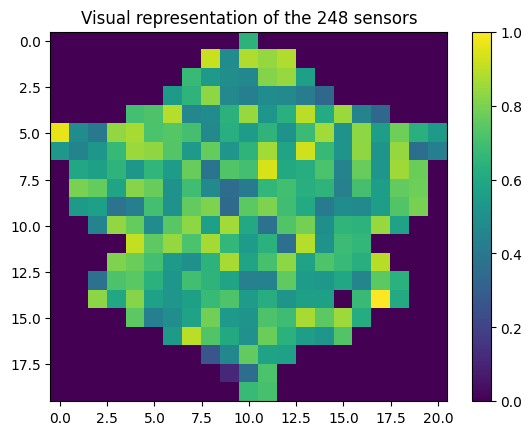

In [19]:
def convert_to_mesh(trainx):
    meshes = []
    for scan in trainx:
        mesh_per_timestamp = []
        for i in range(scan.shape[1]): 
            single_timestamp = scan[:,i]
            reshaped_array = single_timestamp.reshape(1, -1)
            mesh = array_to_mesh(reshaped_array)
            mesh_per_timestamp.append(mesh)
        meshes.append(mesh_per_timestamp)
    return meshes

trainx_mesh = convert_to_mesh(trainx)
print(np.shape(trainx_mesh))


# show one example mesh, first scan, first timestamp, array with shape (20,21)
plt.imshow(trainx_mesh[0][0], cmap='viridis', aspect='auto')
plt.title('Visual representation of the 248 sensors')
plt.colorbar()
plt.show()


MovieWriter Pillow unavailable; using Pillow instead.


Animation saved as 'animation.mp4'


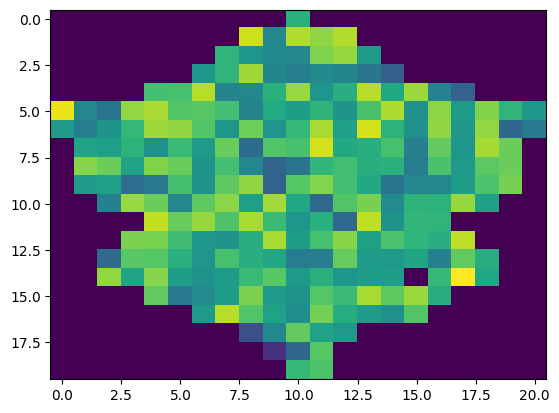

In [21]:
from matplotlib.animation import FuncAnimation


# Set up the initial figure and axes
fig, ax = plt.subplots()
img = ax.imshow(trainx_mesh[0][0], cmap='viridis', aspect='auto')

# Function to update the plot for each frame of the animation
def update(frame):
    img.set_array(trainx_mesh[0][frame])
    return img,

# Create the animation
animation = FuncAnimation(fig, update, frames=1980, interval=50, blit=True)

# Save the animation as a video file (e.g., MP4)
animation.save('animation.gif', writer='Pillow', fps=30)

# Show a message indicating the save was successful
print("Animation saved as 'animation.mp4'")

In [ ]:
from sklearn.metrics import confusion_matrix

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(248, input_shape=(trainx.shape[1],trainx.shape[2])))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(248, activation='relu'))
model.add(tf.keras.layers.Dense(trainy.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), metrics=['accuracy'])
verbose, epochs, batch_size = 0, 30, 64

model.fit(trainx, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)

predictions = model.predict(testx)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(testy, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)
print(cm)
_, accuracy = model.evaluate(testx, testy, batch_size=batch_size, verbose=0)
print(accuracy)

Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x12e1ff7f0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function Model.make_train_function.<locals>.train_function at 0x12e1ff7f0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not 